# The NEF algorithm

While Nengo provides a flexible,
general-purpose approach to neural modelling,
some aspects rely on the Neural Engineering Framework (NEF)
to help specify network behavior.
The theory behind the Neural Engineering Framework
is developed at length in
[Eliasmith & Anderson, 2003: "Neural Engineering"](
https://mitpress.mit.edu/books/neural-engineering)
and a short summary is available in
[Stewart, 2012: "A Technical Overview of the Neural Engineering Framework"](
http://compneuro.uwaterloo.ca/publications/stewart2012d.html).

However, for some people,
the best description of an algorithm
is the code itself.
With that in mind,
the following is a complete implementation of the NEF
for the special case of
two one-dimensional populations with a single connection between them.
You can adjust the function being computed,
the input to the system,
and various neural parameters.

This example does not use Nengo at all.
It is Python code that only requires
Numpy (for the matrix inversion)
and Matplotlib (to produce graphs of the output).

## Introduction

The NEF is a method for building large-scale neural models
using realistic neurons.
It is a neural compiler:
you specify the high-level computations the model needs to compute,
and the properties of the neurons themselves,
and the NEF determines the neural connections
needed to perform those operations.

This script shows how to build a
simple feed-forward network of leaky integrate-and-fire neurons
where each population encodes a one-dimensional value
and the connection weights between the populations
are optimized to compute some arbitrary function.
This same approach is used in Nengo,
extended to multi-dimensional representation,
multiple populations of neurons, and recurrent connections.

To change the input to the system, change `input`.
To change the function computed by the weights, change `function`.

The size of the populations and their neural properties
can also be adjusted by changing the parameters below.

In [1]:
%matplotlib inline

import math
import random

import numpy
import matplotlib.pyplot as plt

dt = 0.001  # simulation time step
t_rc = 0.02  # membrane RC time constant
t_ref = 0.002  # refractory period
t_pstc = 0.1  # post-synaptic time constant
N_A = 50  # number of neurons in first population
N_B = 40  # number of neurons in second population
N_samples = 100  # number of sample points to use when finding decoders
rate_A = 25, 75  # range of maximum firing rates for population A
rate_B = 50, 100  # range of maximum firing rates for population B


def input(t):
    """The input to the system over time"""
    return math.sin(t)


def function(x):
    """The function to compute between A and B."""
    return x * x

## Step 1: Initialization

In [2]:
# create random encoders for the two populations
encoder_A = [random.choice([-1, 1]) for i in range(N_A)]
encoder_B = [random.choice([-1, 1]) for i in range(N_B)]


def generate_gain_and_bias(count, intercept_low, intercept_high, rate_low, rate_high):
    gain = []
    bias = []
    for _ in range(count):
        # desired intercept (x value for which the neuron starts firing
        intercept = random.uniform(intercept_low, intercept_high)
        # desired maximum rate (firing rate when x is maximum)
        rate = random.uniform(rate_low, rate_high)

        # this algorithm is specific to LIF neurons, but should
        # generate gain and bias values to produce the desired
        # intercept and rate
        z = 1.0 / (1 - math.exp((t_ref - (1.0 / rate)) / t_rc))
        g = (1 - z) / (intercept - 1.0)
        b = 1 - g * intercept
        gain.append(g)
        bias.append(b)
    return gain, bias


# random gain and bias for the two populations
gain_A, bias_A = generate_gain_and_bias(N_A, -1, 1, rate_A[0], rate_A[1])
gain_B, bias_B = generate_gain_and_bias(N_B, -1, 1, rate_B[0], rate_B[1])


def run_neurons(input, v, ref):
    """Run the neuron model.

    A simple leaky integrate-and-fire model, scaled so that v=0 is resting
    voltage and v=1 is the firing threshold.
    """
    spikes = []
    for i, _ in enumerate(v):
        dV = dt * (input[i] - v[i]) / t_rc  # the LIF voltage change equation
        v[i] += dV
        if v[i] < 0:
            v[i] = 0  # don't allow voltage to go below 0

        if ref[i] > 0:  # if we are in our refractory period
            v[i] = 0  # keep voltage at zero and
            ref[i] -= dt  # decrease the refractory period

        if v[i] > 1:  # if we have hit threshold
            spikes.append(True)  # spike
            v[i] = 0  # reset the voltage
            ref[i] = t_ref  # and set the refractory period
        else:
            spikes.append(False)
    return spikes


def compute_response(x, encoder, gain, bias, time_limit=0.5):
    """Measure the spike rate of a population for a given value x."""
    N = len(encoder)  # number of neurons
    v = [0] * N  # voltage
    ref = [0] * N  # refractory period

    # compute input corresponding to x
    input = []
    for i in range(N):
        input.append(x * encoder[i] * gain[i] + bias[i])
        v[i] = random.uniform(0, 1)  # randomize the initial voltage level

    count = [0] * N  # spike count for each neuron

    # feed the input into the population for a given amount of time
    t = 0
    while t < time_limit:
        spikes = run_neurons(input, v, ref)
        for i, s in enumerate(spikes):
            if s:
                count[i] += 1
        t += dt
    return [c / time_limit for c in count]  # return the spike rate (in Hz)


def compute_tuning_curves(encoder, gain, bias):
    """Compute the tuning curves for a population"""
    # generate a set of x values to sample at
    x_values = [i * 2.0 / N_samples - 1.0 for i in range(N_samples)]

    # build up a matrix of neural responses to each input (i.e. tuning curves)
    A = []
    for x in x_values:
        response = compute_response(x, encoder, gain, bias)
        A.append(response)
    return x_values, A


def compute_decoder(encoder, gain, bias, function=lambda x: x):
    # get the tuning curves
    x_values, A = compute_tuning_curves(encoder, gain, bias)

    # get the desired decoded value for each sample point
    value = numpy.array([[function(x)] for x in x_values])

    # find the optimal linear decoder
    A = numpy.array(A).T
    Gamma = numpy.dot(A, A.T)
    Upsilon = numpy.dot(A, value)
    Ginv = numpy.linalg.pinv(Gamma)
    decoder = numpy.dot(Ginv, Upsilon) / dt
    return decoder


# find the decoders for A and B
decoder_A = compute_decoder(encoder_A, gain_A, bias_A, function=function)
decoder_B = compute_decoder(encoder_B, gain_B, bias_B)

# compute the weight matrix
weights = numpy.dot(decoder_A, [encoder_B])

## Step 2: Running the simulation

In [3]:
v_A = [0.0] * N_A  # voltage for population A
ref_A = [0.0] * N_A  # refractory period for population A
input_A = [0.0] * N_A  # input for population A

v_B = [0.0] * N_B  # voltage for population B
ref_B = [0.0] * N_B  # refractory period for population B
input_B = [0.0] * N_B  # input for population B

# scaling factor for the post-synaptic filter
pstc_scale = 1.0 - math.exp(-dt / t_pstc)

# for storing simulation data to plot afterward
inputs = []
times = []
outputs = []
ideal = []

output = 0.0  # the decoded output value from population B
t = 0
while t < 10.0:  # noqa: C901 (tell static checker to ignore complexity)
    # call the input function to determine the input value
    x = input(t)

    # convert the input value into an input for each neuron
    for i in range(N_A):
        input_A[i] = x * encoder_A[i] * gain_A[i] + bias_A[i]

    # run population A and determine which neurons spike
    spikes_A = run_neurons(input_A, v_A, ref_A)

    # decay all of the inputs (implementing the post-synaptic filter)
    for j in range(N_B):
        input_B[j] *= 1.0 - pstc_scale
    # for each neuron that spikes, increase the input current
    # of all the neurons it is connected to by the synaptic
    # connection weight
    for i, s in enumerate(spikes_A):
        if s:
            for j in range(N_B):
                input_B[j] += weights[i][j] * pstc_scale

    # compute the total input into each neuron in population B
    # (taking into account gain and bias)
    total_B = [0] * N_B
    for j in range(N_B):
        total_B[j] = gain_B[j] * input_B[j] + bias_B[j]

    # run population B and determine which neurons spike
    spikes_B = run_neurons(total_B, v_B, ref_B)

    # for each neuron in B that spikes, update our decoded value
    # (also applying the same post-synaptic filter)
    output *= 1.0 - pstc_scale
    for j, s in enumerate(spikes_B):
        if s:
            output += decoder_B[j][0] * pstc_scale

    if t % 0.5 <= dt:
        print(t, output)
    times.append(t)
    inputs.append(x)
    outputs.append(output)
    ideal.append(function(x))
    t += dt

0 0.0
0.001 0.0
0.5000000000000003 0.12018656370863653
1.0000000000000007 0.5285961078559024


1.5009999999999455 0.9219832060725917
2.0009999999998906 0.8905984542273456
2.5009999999998356 0.5361898088696772


3.0009999999997805 0.1290931286957084
3.5009999999997254 0.06530550059067206
4.000999999999671 0.4055686302685108


4.500999999999838 0.8497443986268921
5.000000000000004 0.9530396769017555
5.500000000000171 0.6718201792652034


6.000000000000338 0.23667346689769544
6.500000000000505 0.026771337926871325
7.000000000000672 0.2966974457203748


7.500000000000839 0.7333501597389251
8.000000000001005 0.9660944284951636
8.500000000000728 0.7895321389482932


9.000000000000451 0.3144277692357002
9.500000000000174 0.026094936856604772


## Step 3: Plot the results

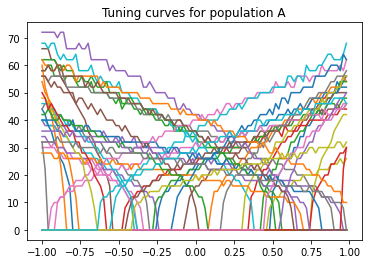

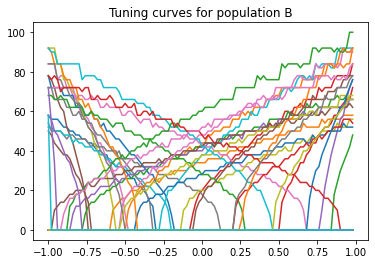

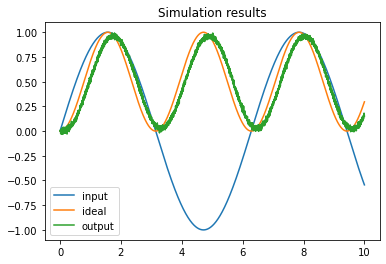

In [4]:
x, A = compute_tuning_curves(encoder_A, gain_A, bias_A)
x, B = compute_tuning_curves(encoder_B, gain_B, bias_B)

plt.figure()
plt.plot(x, A)
plt.title("Tuning curves for population A")

plt.figure()
plt.plot(x, B)
plt.title("Tuning curves for population B")

plt.figure()
plt.plot(times, inputs, label="input")
plt.plot(times, ideal, label="ideal")
plt.plot(times, outputs, label="output")
plt.title("Simulation results")
plt.legend()
plt.show()